In [6]:
import keras
keras.__version__

'2.2.2'

# Classification des critiques de films: un exemple de classification binaire

La classification à deux classes, ou classification binaire, peut être le type de problème d’apprentissage automatique le plus largement appliqué. Dans cet exemple, nous apprendra à classer les critiques de films en critiques "positives" et "négatives", uniquement en fonction du contenu textuel des critiques.

## The IMDB dataset

Nous allons travailler avec "l'ensemble de données IMDB", un ensemble de 50 000 critiques de la base de données Internet Movie. Ils sont divisés en 25 000 revues pour l'apprentissage et 25 000 revues pour les tests, chaque série comprenant 50% de critiques négatives et 50% de critiques positives.

Tout comme le jeu de données MNIST, le jeu de données IMDB est fourni avec Keras. 

Il a déjà été prétraité: les critiques (séquences de mots) ont été transformés en séquences d’entiers, chaque entier représentant un mot spécifique dans un dictionnaire.

Le code suivant chargera le jeu de données (lorsque vous l'exécuterez pour la première fois, environ 80 Mo de données seront téléchargés sur votre ordinateur):

In [7]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


- `num_words = 10000` signifie que nous ne conserverons que les 10 000 mots les plus fréquents dans les données d'apprentissage. Cela nous permet de travailler avec des données vectorielles de taille gérable.

- `train_data` et` test_data` sont des listes de revues, chaque revue étant une liste d'index de mots (codant une séquence de mots). 
- `train_labels` et` test_labels` sont des listes de 0 et de 1, où 0 signifie "négatif" et 1, "positif"

Voici comment décoder une revue :

In [10]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[3]])

## Préparation des données


Nous ne pouvons pas introduire de listes d'entiers dans un réseau de neurones. Nous devons transformer nos listes en tenseurs. Nous pouvons le faire de deux manières :

- Nous pourrions compiler nos listes pour qu’elles aient toutes la même longueur et les transformer en un tenseur entier de forme `(samples, word_indices)`, puis utiliser comme première couche de notre réseau une couche capable de gérer de tels tenseurs entiers (la couche `Embedding`).

- Nous pourrions coder à chaud nos listes pour les transformer en vecteurs de 0 et de 1. Concrètement, cela signifierait, par exemple, tourner la séquence `[3, 5]` dans un vecteur de 10 000 dimensions qui serait composé de zéros sauf les indices 3 et 5, qui seraient un. Ensuite, nous pourrions utiliser comme première couche de notre réseau, une couche `Dense`, capable de traiter des données vectorielles à virgule flottante.

Nous utilisons cette dernière solution. Vectorisons nos données, ce que nous ferons manuellement pour une clarté maximale:

In [12]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

On vectorise aussi nos labels :

In [18]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')


## Construire notre réseau

Nos données d'entrée sont simplement des vecteurs et nos étiquettes sont des scalaires (1 et 0): c'est la configuration la plus simple. 

Un réseau qui fonctionne bien sur un tel problème serait une simple pile de couches entièrement connectées (`Dense`) avec les activations `relu`: `Dense (16,activation = 'relu')`

L'argument transmis à chaque couche `Dense` (16) est le nombre d'unités cachées de la couche. 

## Qu'est-ce qu'une unité cachée? 

C'est une dimension dans l'espace de représentation de la couche. 


Avoir 16 unités cachées signifie que la matrice de pondération "W" aura la forme "(input_dimension, 16)", c’est-à-dire que le produit scalaire avec "W" projettera les données dans un espace de représentation à 16 dimensions 


Vous pouvez comprendre intuitivement la dimensionnalité de votre espace de représentation comme "la liberté que vous donnez au réseau quand vous apprendre les représentations internes ". 


Avoir plus d'unités cachées (un espace de représentation de dimension supérieure) permet à votre réseau d'apprendre des
représentations plus complexes


Il faut prendre deux décisions d’architecture importantes concernant cet empilement de couches denses:

* Combien de couches à utiliser.
* Combien d'unités cachées choisir pour chaque couche.

Un `relu` (unité linéaire rectifiée) est une fonction destinée à mettre à zéro les valeurs négatives,
tandis qu'un sigmoïde "écrase" des valeurs arbitraires dans l'intervalle `[0, 1]`, générant ainsi quelque chose qui peut être interprété comme une probabilité.

Voici l'implémentation Keras :

In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Enfin, nous devons choisir une fonction de perte et un optimiseur. 

Puisque nous sommes confrontés à un problème de classification binaire et à la sortie de notre réseau est une probabilité, il est préférable d'utiliser la perte `binary_crossentropy`.

Ce n'est pas le seul choix viable: vous pouvez utiliser, par exemple, `mean_squared_error`. Mais la cross-centropie est généralement le meilleur choix lorsque vous traitent des modèles qui produisent des probabilités. 

Voici l'étape où nous configurons notre modèle avec l'optimiseur `rmsprop` et la fonction de perte` binary_crossentropy`. Notez que nous allons surveillez également la précision pendant l'apprentissage.

In [14]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## Valider notre approche

Afin de contrôler au cours de l'apprentissage la précision du modèle sur des données qu’il n’a jamais vues auparavant, nous allons créer un "jeu de validation" avec 10 000 échantillons des données d'entraînement originales :

In [19]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Nous allons maintenant former notre modèle pour 20 époques (20 itérations sur tous les échantillons des tenseurs `x_train` et` y_train`), en mini-lots de 512 échantillons. 

Parallèlement, nous surveillerons la perte et la précision des 10 000 échantillons que nous avons mis de côté. Ceci est fait en passant les données de validation en tant qu'argument `validation_data`:

In [29]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 5s 339us/step - loss: 0.1399 - acc: 0.9518 - val_loss: 0.1406 - val_acc: 0.9522
Epoch 2/20
15000/15000 [==============================] - 4s 271us/step - loss: 0.1178 - acc: 0.9607 - val_loss: 0.1571 - val_acc: 0.9422
Epoch 3/20
15000/15000 [==============================] - 4s 272us/step - loss: 0.0959 - acc: 0.9713 - val_loss: 0.1679 - val_acc: 0.9385
Epoch 4/20
15000/15000 [==============================] - 4s 266us/step - loss: 0.0793 - acc: 0.9769 - val_loss: 0.1855 - val_acc: 0.9326
Epoch 5/20
15000/15000 [==============================] - 4s 268us/step - loss: 0.0671 - acc: 0.9807 - val_loss: 0.2037 - val_acc: 0.9254
Epoch 6/20
15000/15000 [==============================] - 4s 267us/step - loss: 0.0535 - acc: 0.9867 - val_loss: 0.2368 - val_acc: 0.9165
Epoch 7/20
15000/15000 [==============================] - 4s 267us/step - loss: 0.0445 - acc: 0.9891 - val_loss: 0.2513 - 

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

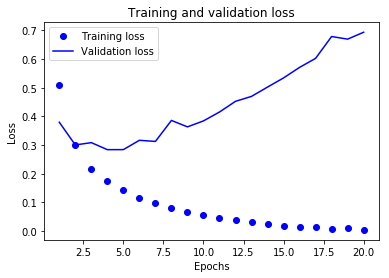

In [23]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

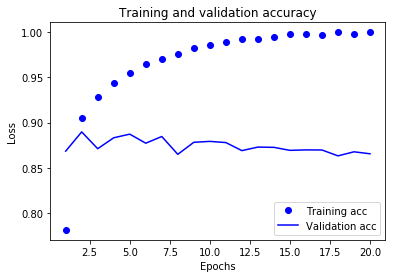

In [25]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Les points représentent la perte et la précision de l'apprentissage, tandis que les traits pleins représentent la perte et la précision de la validation. 

Pour combler ce problème, on pourrait tester :

In [26]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 2s 91us/step - loss: 0.4749 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 2s 82us/step - loss: 0.2658 - acc: 0.9097
Epoch 3/4
25000/25000 [==============================] - 2s 81us/step - loss: 0.1982 - acc: 0.9299
Epoch 4/4
25000/25000 [==============================] - 3s 101us/step


In [27]:
results

[0.32443902156829835, 0.87296]


## Utiliser un réseau pour générer des prévisions sur de nouvelles données

Après avoir formé un réseau, vous souhaiterez l’utiliser de manière pratique. Vous pouvez générer la probabilité que les avis soient positifs en utilisant la méthode `Predict`:

In [28]:
model.predict(x_test)

array([[0.13948491],
       [0.999701  ],
       [0.28898463],
       ...,
       [0.07168164],
       [0.04301627],
       [0.4793026 ]], dtype=float32)


## Autres expériences


* Nous utilisions 2 couches cachées. Essayez d'utiliser 1 ou 3 couches cachées et voyez comment cela affecte la validation et la précision des tests.
* Essayez d'utiliser des couches avec plus d'unités cachées ou moins: 32 unités, 64 unités ...
* Essayez d’utiliser la fonction de perte `mse` au lieu de` binary_crossentropy`.
* Essayez d'utiliser l'activation `tanh` (une activation qui était populaire dans les premiers jours des réseaux de neurones) au lieu de` relu`.